## Global variables

In [27]:
# Global variable containing all corpus
datas = {}
# List of corpus to load 
files = ['moviereview', 'climatechange', 'sentiment140']

## Class that contain and manipulate the corpus

In [332]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from string import punctuation
import pandas as pd
import numpy as np
from re import sub

# Punctuation to remove
punctuation += '1234567890\n'
trans = str.maketrans(punctuation, ' ' * len(punctuation))
# Analyzer for the CountVectorizer
analyzer = CountVectorizer().build_analyzer()
# Stopwords
stop_words = set(stopwords.words('english'))
stop_words.add('br')

# Used in the function analyze
def remove_url(text):
    return sub('http\S+|www.\S+', 'thiswasalink', text, flags=re.IGNORECASE)

# Preprocessing include lowercase and removing stopwords, punctuation and duplicate consecutive characters (3+)
def analyze(text):
    # regex -> https://stackoverflow.com/questions/1660694/regular-expression-to-match-any-character-being-repeated-more-than-10-times
    words = []
    for w in analyzer(remove_url(text.lower()).translate(trans)):
        pw = sub(r'(.)\1{2,}', r'\1', w)
        if pw not in stop_words:
            words.append(pw)
    return words

In [333]:
class Data:
    # File: Name of the csv file which is in the directory data/
    # Force : If false, it will get the last value of the bag_words calculated in datas
    def __init__(self, file, force=False):
        if datas and file in datas and not force:
            self.data = datas[file].data
            self.vectorizer = datas[file].vectorizer
            self.bag_words = datas[file].bag_words
        else:
            self.data = pd.read_csv('data/{}.csv'.format(file))
            self.bag_words = None
        self.vocabulary = None
        self.text = self.data.text
        self.target = self.data.target
        self.name = file.capitalize()
        if self.bag_words is None:
            self.__preprocess()
    
    # Private function that create the bag of word with a CountVectorizer 
    def __preprocess(self):
        self.vectorizer = CountVectorizer(lowercase=False,
                                          analyzer=analyze)
        self.bag_words = self.vectorizer.fit_transform(self.text)
    
    # Return the n most common words in the corpus
    def get_top_words(self, n=20):
        if self.vocabulary is None:
            bag_sums = self.bag_words.sum(axis=0)
            self.vocabulary = [(w, bag_sums[0, i]) for w, i in self.vectorizer.vocabulary_.items()]
            self.vocabulary = sorted(self.vocabulary, key = lambda x: x[1], reverse=True)
        return self.vocabulary[:n]

In [334]:
force = False # See constructor of Data for details
for file in files:
    datas[file] = Data(file, force)

## Exploratory Data Analysis (EDA)

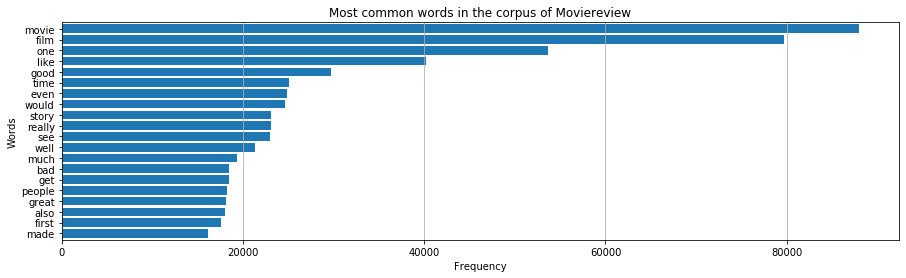

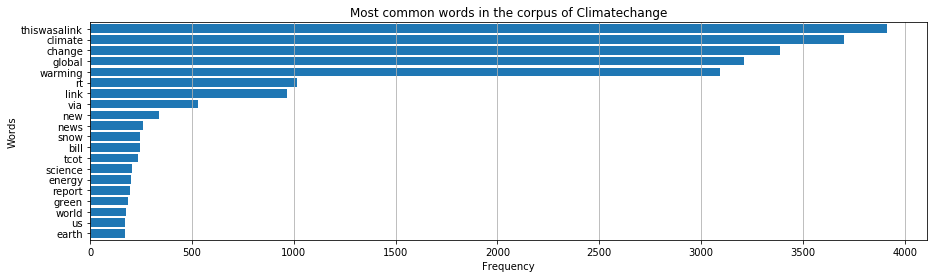

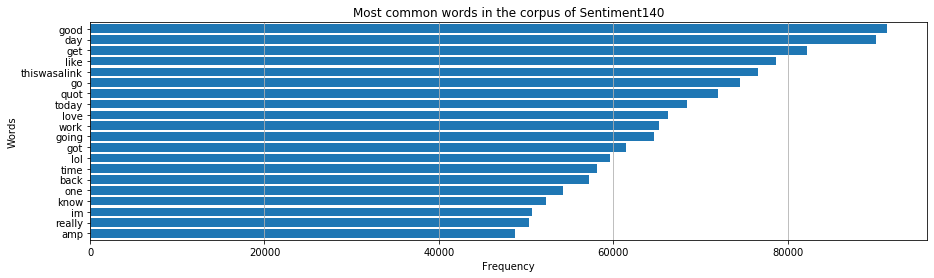

In [335]:
import matplotlib.pyplot as plt

# Display the n most common words of each corpus in datas in a bar graph
def plot_top_words(n=50):
    for _, data in datas.items():
        top = data.get_top_words(n)
        x, y = [], []
        for w, f in top:
            x.insert(0, w)
            y.insert(0, f)
        plt.figure(figsize=(15, n // 5))
        plt.barh(x, y)
        plt.margins(y=0.01)
        plt.grid(True, axis='x')
        plt.ylabel('Words')
        plt.xlabel('Frequency')
        plt.title("Most common words in the corpus of " + data.name)
        plt.show()
        
plot_top_words(20)